In [4]:
import torch
import numpy as np
import music21
import matplotlib.pyplot as plt
from musegan.dataset import postprocess

# The Idea of MuseGAN
### Music Generation
The structure of music is complex. There are four main sections of the generater that describes any music piece:
- style section to generate the vector that correspons the stle of the song
- tracks section to generate commands for every instrument in the song
- chord section changes its commands at the beginning of each measure. This gives each measure a special musical character
- the melody section gives different commands for each instrumental track at the beginning of each measure and has the most control over the music

Our MuseGAN generater must process four random vectors to generate the song

# Temporal Network
The music shouldn't be generated bar by bar with possibly no coherence among the
bars. Because of that we need to use some model to generate music of a few bars long, such as musical phrase. Such submodel, so-called Temporal model, have been provided.

Temporal Network maps a noise vector $z$ to a sequence of some latent vectors $\{z_t\}_{t=1}^T$ which is expected to carry temporal information. The temporal network cosists of two  transposed convolution layers with Batch Normalization and ReLU activation. 

In [6]:
from musegan.generator import TemporalNetwork # import the temporal network

tempnet = TemporalNetwork()    # Initialize with default parameters

a = torch.rand(10, 32)     # Random vector of size [n_samples, latent_vector_dimension]
print(tempnet(a).shape)    # Vector of size [n_samples, latent_vector_dimension, n_bars=2]

del tempnet, a

torch.Size([10, 32, 2])


# Bar Generator
- The bar generator converts a vector of length $4* z_{dim}$ into one bar for one batch, i.e. into a tensor with the form [1, 1, n_step_per_bar, n_pitches]

- The input vector is created by combining the four vectors of chords, styles, melodies and tracks, each of which has a length of $z_{dim}$

- The bar generator is a neural network that uses layers of transposed convolution to increase the dimensions corresponding to time and notes

In [7]:
from musegan.generator import BarGenerator # import the bar generator

bargenerator = BarGenerator()    # Initialize with default parameters: 
                                 # z_dim=32, n_steps_per_bar=16, n_pitches=84

a = torch.rand(10, 128)          # Random vector of size [n_samples, 4 * z_dim]
print(bargenerator(a).shape)     # Vector of size [n_samples, 1, 1, n_steps_per_bar, n_pitches]

del bargenerator, a

torch.Size([10, 1, 1, 16, 84])


# MuseGAN Generator
In general, the MuseGAN network has a single generator that includes all the Temporal Networks and Bar Generators. This network takes four input tensors and converts them into a score with multiple bars and parts. 

The scheme of the network is shown below:
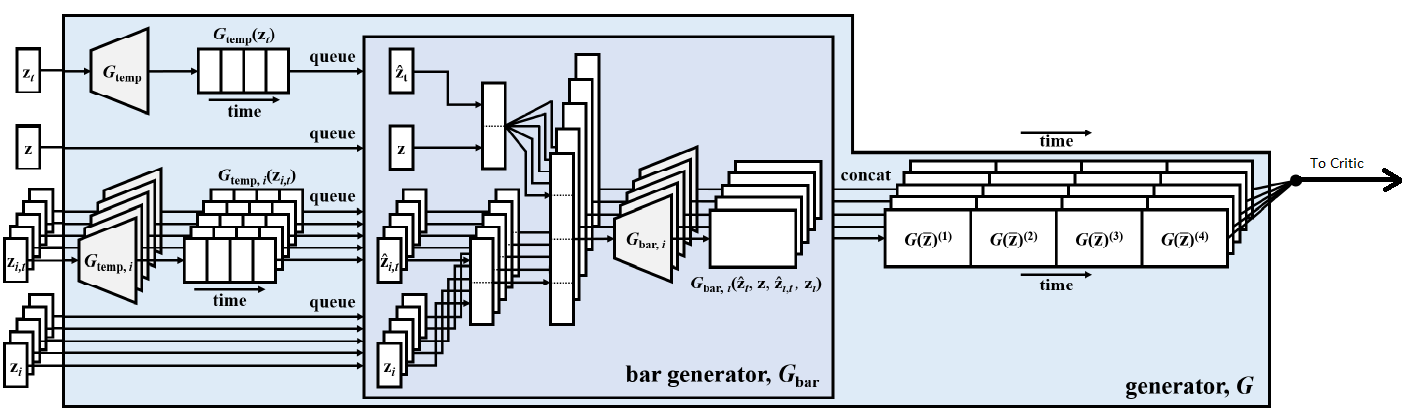

<a id='untrained'></a>

In [8]:
from musegan.generator import Generator   # import MuseGAN Generator

generator = Generator()                   # Initialize with default parameters
                                          # z_dim=32, n_tracks=4, n_bars=2
                                          # n_steps_per_bar=16, n_pitches=84

chords = torch.rand(10, 32)
style = torch.rand(10, 32)
melody = torch.rand(10, 4, 32)
tracks = torch.rand(10, 4, 32)

print(generator(chords, style, melody, tracks).shape)   # [n_samples, n_tracks, n_bars, n_steps_per_bar, n_pitches]
postprocess(generator(chords, style, melody, tracks).detach()).show('midi') # Listen the fully random music piece

del generator, chords, style, melody, tracks

torch.Size([10, 4, 2, 16, 84])


# MuseGAN Critic
The critic for the MuseGAN is quite normal for the GAN architecture. This is a simpler structure than the generator, which consists of Conv3D layers that collapse the score into a single output prediction. The critic tries to distinguish the score created by the generator from fragments of real Bach chorales.

Because of the Wasserstein loss with gradient penalty will be used for thaining, it is forbidden to use any normalize layers in the Critic structure.

In [10]:
from musegan.critic import Critic    # import MuseGAN Critic

In [11]:
critic = Critic()                     # Initialize with default parameters 
                                      # n_tracks=4, n_bars=2
                                      # n_steps_per_bar=16, n_pitches=84
    

a = torch.rand(10, 4, 2, 16, 84)      # [n_samples, n_tracks, n_bars, n_steps_per_bar, n_pitches]
print(critic(a).shape)                # [n_samples, 1]

del critic, a

torch.Size([10, 1])


# Dataset Loader
In that project the dataset of 229 chorales of Bach for four tracks is used. 

The dataset could be found [here](http://bit.ly/2HYISrC). The dataset cosists of array of four number for every time step - note pitch for each of the four tracks. Every bar is devided on 16 time steps

<a id='Bach'></a>

In [12]:
from torch.utils.data import DataLoader
from musegan.dataset import MidiDataset, postprocess

In [13]:
dataset = MidiDataset(path='data/Jsb16thSeparated.npz')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

In [18]:
# Example of dataset
postprocess(dataset[:4]).show('midi')

# Complete MuseGAN model
Out complete MuseGAN network combines the Muse Generator and Muse Critic. 

In [19]:
from musegan.musegan import MuseGAN

In [20]:
musegan = MuseGAN(
                    z_dimension=32,
                    g_channels=1024,
                    g_features=1024,
                    c_channels=128,
                    c_features=1024,
                    n_bars=2,
                    n_tracks=4,
                    n_steps_per_bar=16,
                    n_pitches=84
                    )

MuseGAN initialized


## Train the model
There is a standard GAN training procedure. The critic loss funcion is WassersteinLoss with Gradient Penalty. The generator loss is just a WassersteinLoss.  On every train iteration the critic trains five times while the generater just once. 

### Critic training process
First of all we randomly generate melodies useing the generator for every critic training itteration (the same number samples as a batch_size). We marked faked samples as -1 while real as 1. Afterwhat the critic tries to distinguish between real samples and generated ones. The loss for fake and real samples is calculated separatly using WassersteinLoss. 

The Gradient Penalty is calculated using the mix of 'real' and 'fake' melody. The mixture parameter is randomly selected for every sample in the batch. 

The resulting loss is defined as follow: $CriticLoss=FakeLoss+RealLoss+GradientPenalty$

### Generator training process
We generate new fake samples. The loss is constructed using a fool critic approach. In the approach we mark every sample (real or fake) as a real one and put them forward to critic. The generator loss is a WassersteinLoss of Critic fool predictions. 

In [6]:
musegan.train(dataloader, epochs=300, batch_size=64, display_epoch=1)

Epoch 299/300 G loss: -23.041 D loss: -14.172 ETA: 1.802s [C loss | (fake: 18.218, real: -36.142, penalty: 3.752)]: 100


## Losses behavior

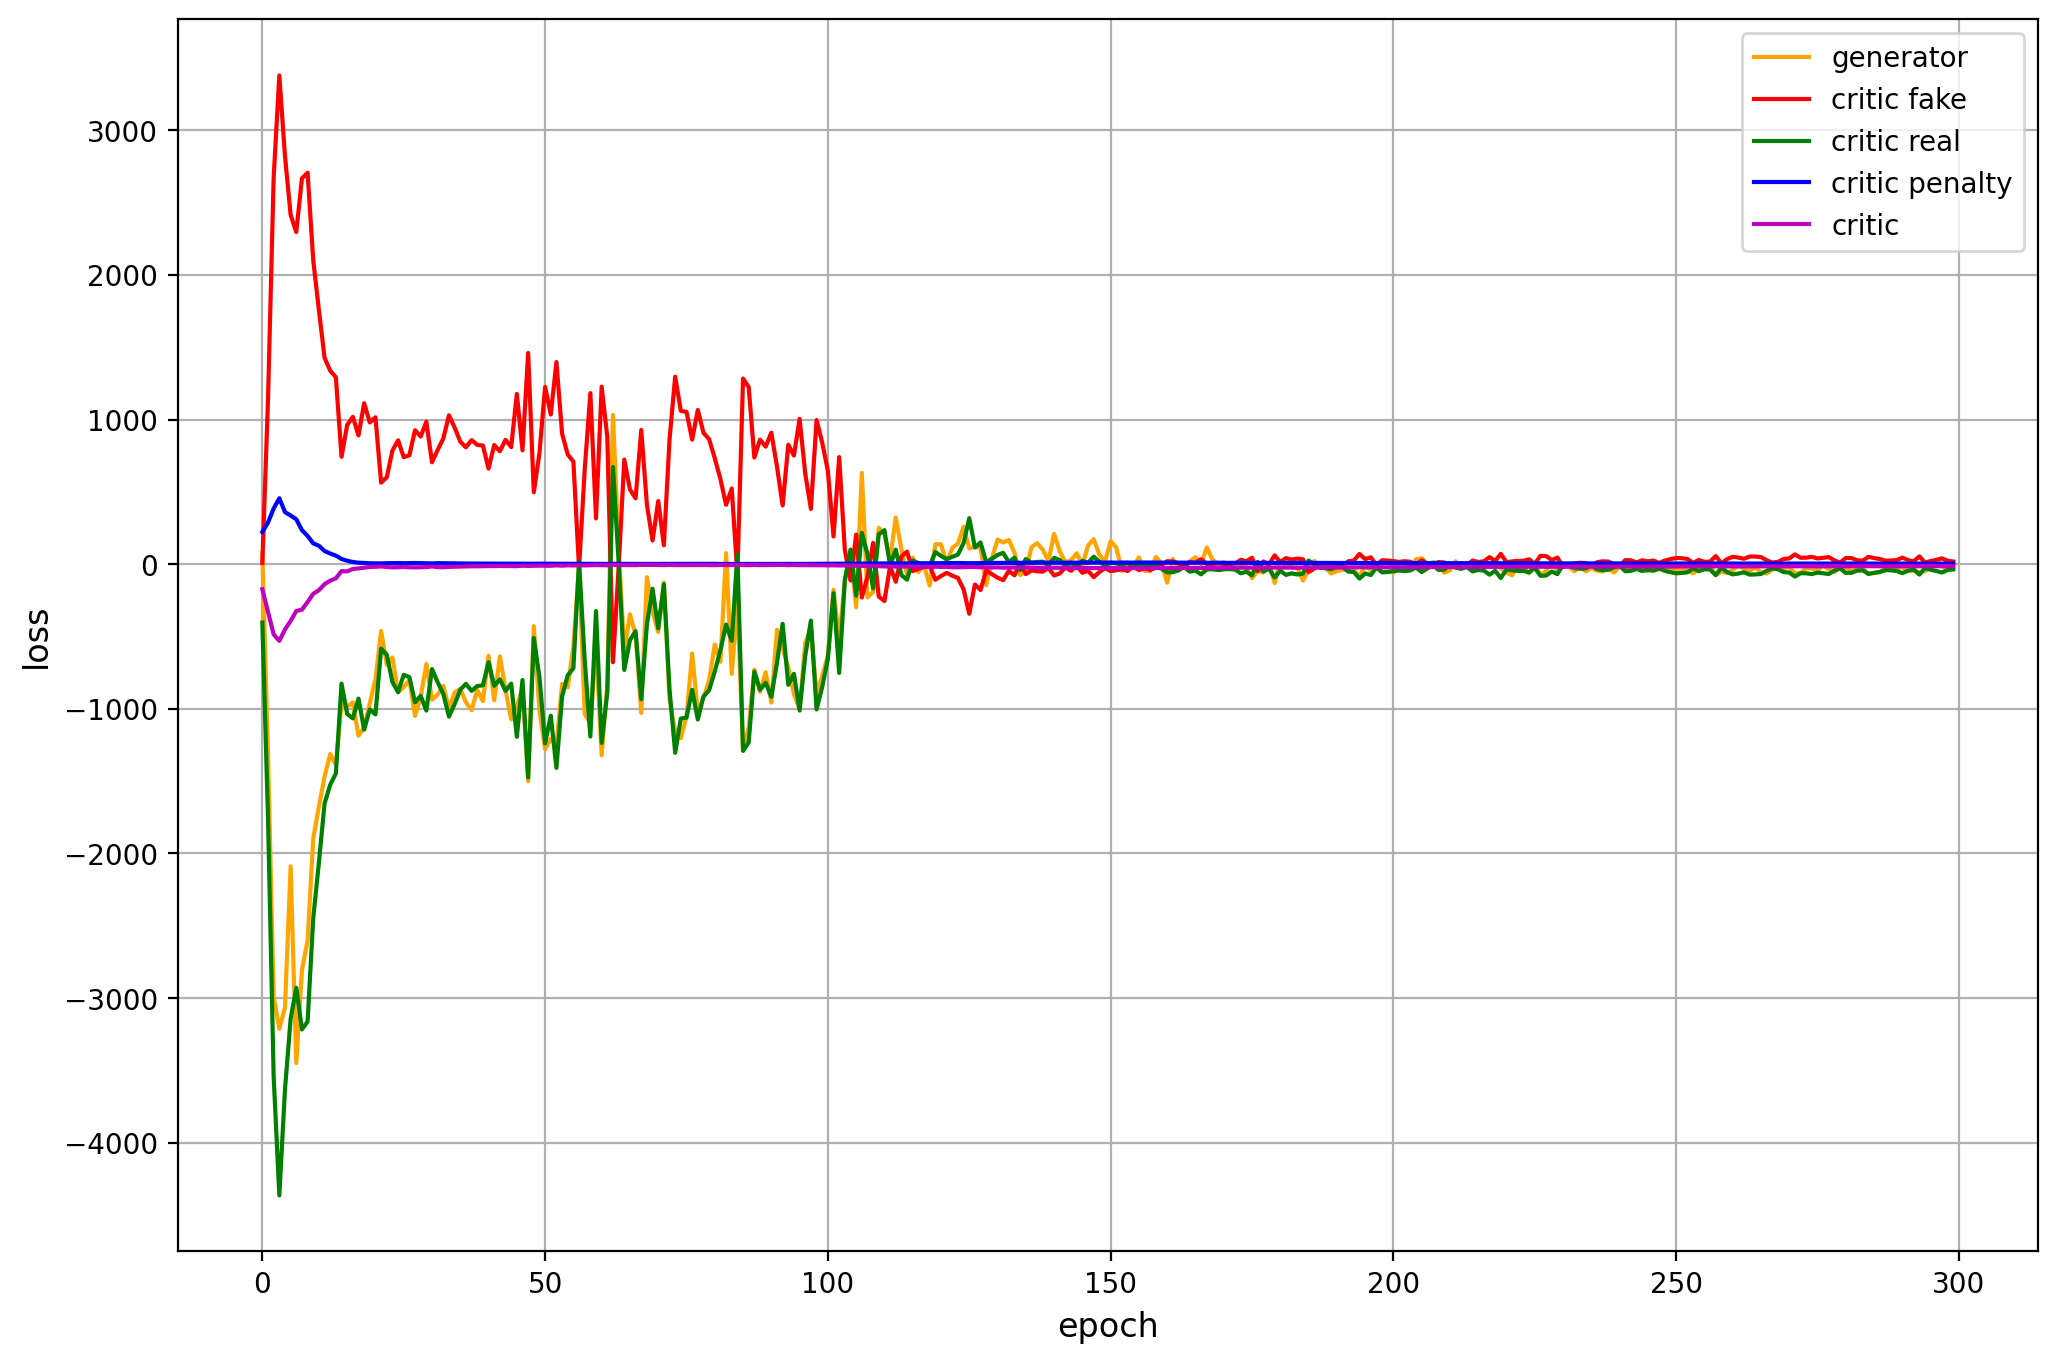

In [11]:
losses = musegan.history.copy()
plt.figure(figsize=(12, 8))
plt.plot(losses['g_loss'][:300], 'orange', label='generator')
plt.plot(losses['cf_loss'][:300], 'r', label='critic fake')
plt.plot(losses['cr_loss'][:300], 'g', label='critic real')
plt.plot(losses['cp_loss'][:300], 'b', label='critic penalty')
plt.plot(losses['c_loss'][:300], 'm', label='critic')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid()
plt.legend();

## Generate new melody

In [21]:
musegan.generator.eval().cpu()

chords = torch.rand(4, 32)      
style = torch.rand(4, 32)
melody = torch.rand(4, 4, 32)
tracks = torch.rand(4, 4, 32)

preds = musegan.generator(chords, style, melody, groove).detach() # fake melody

In [23]:
music_data = postprocess(preds)   # transform tensor to midi 
music_data.show('midi')           # Play midi

Now you can compair the result with [Untrained generator](#untrained) and [real Bach melody](#Bach)

In [24]:
# Save midi to file 
filename = 'fake_midi.midi'
music_data.write('midi', fp=filename)

'fake_midi.midi'